In [1]:
import operator
from typing import Annotated, TypedDict

from langchain_community.document_loaders import WikipediaLoader
from langchain_core.tools import Tool, tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field

In [ ]:
research_brief = """How can I develop an agentic AI-powered note-taking application leveraging LangGraph for my personal use, with features including image-to-text conversion, formatting, and integration with Notion, while showcasing my skills? I am seeking to:

1. Employ a robust Optical Character Recognition (OCR) solution for converting handwritten notes, potentially containing equations and block diagrams, into digital text.
   - Specific OCR tool preferences are currently open-ended; the research should explore both existing solutions and state-of-the-art alternatives.

2. Customize LangGraph's prebuilt UI for seamless interaction from a PC without any specific customization specifications, leaving room for creative design choices.

3. Develop a seamless interface with Notion, utilizing either existing APIs or custom integration methods.
   - The research should identify the best method for ensuring efficient data management and retrieval in Notion.

4. Implement a multi-agent system where one agent focuses on image-to-text conversion and another takes charge of text integration and formatting using markdown.
   - The interaction dynamics between agents require exploration to ensure efficiency and smooth operation.

5. Deliver an initial MVP capable of converting images to well-formatted text within 2 weeks.

6. Maintain an open architectural design, allowing flexibility in programming languages and frameworks, as no constraints have been specified.

7. Enhance the application to demonstrate my capabilities to potential employers, focusing on cutting-edge approach and effective solutions. """

In [2]:
class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[str, "Description of the project by User"]
    messages: Annotated[
        list[str],
        add_messages,
    ]  # Clarifying questions to refine the project idea by project info colleciton agent
    project_research: Annotated[
        str,
        "Research information generated by research agent",
    ]
    project_plan: Annotated[list[str], operator.add]  # generated by planning Agent/s
    final_report: Annotated[str, "Generated by Report Generation Agent"]


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")


class ResearchState(BaseModel):
    """The state of the research agent."""

    result: Annotated[str, "collect final results after research from the Agent"]

In [ ]:
SEARCH_INSTRUCTIONS = """You are a helpful assistant that searches for information.
When a user asks a question that requires current information or web search,
you MUST use the search_web tool to find the answer. Always search for relevant information before responding."""

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

In [11]:
@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve docs from the web."""
    print("[INFO] search_web tool called")
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + state["messages"],
    )
    tavily_search = TavilySearch(max_results=3)
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>""" for doc in search_docs
    ]

    return {"messages": state["messages"] + formatted_search_docs}


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve docs from Wikipedia."""
    print("[INFO] search_wikipedia tool called")
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + state["messages"],
    )
    search_docs = WikipediaLoader(
        query=search_query.search_query,
        load_max_docs=2,
    ).load()
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>""" for doc in search_docs
    ]

    return {"messages": state["messages"] + formatted_search_docs}


python_repl = PythonREPL()
# You can create the tool to pass to an agent
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)
TOOLS = [search_web, search_wikipedia, repl_tool]
llm_with_tools = llm.bind_tools(TOOLS)

In [12]:
PROJECT_RESEARCH_AGENT_PROMPT = """  You are a helpful assistant that searches the web for information. You will receive a question for user and you will search the web for the answer to the question. you should prepare proper query to search on web or wikipedia"""

In [13]:
def research_agent(state: PlanningState) -> PlanningState:
    """Understand conversation and user web tools or python to peform research."""
    print("[INFO] research_agent called")
    msg_history = state["messages"]
    # system_msg = SystemMessage(PROJECT_RESEARCH_AGENT_PROMPT)

    result = llm_with_tools.invoke(msg_history)
    return {"result": result}

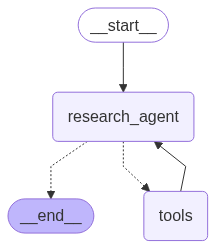

In [14]:
research_agent_graph = StateGraph(
    state_schema=PlanningState,
    output_schema=ResearchState,
)

research_agent_graph.add_node("research_agent", research_agent)
research_agent_graph.add_node("tools", ToolNode(TOOLS))

research_agent_graph.add_edge(START, "research_agent")
research_agent_graph.add_conditional_edges("research_agent", tools_condition)
research_agent_graph.add_edge("tools", "research_agent")


research_agent_workflow = research_agent_graph.compile(
    name="Research Agent",
)
research_agent_workflow

In [15]:
result = research_agent_workflow.invoke(
    {"messages": ["what is latest version of python?"]},
)

[INFO] research_agent called


In [16]:
result

{'result': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ynxWByoKx2KDcleF3OiUaN6j', 'function': {'arguments': '{"state":{"project_description":"","messages":[],"project_research":"","project_plan":[],"final_report":""}}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 198, 'total_tokens': 229, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BuHUMpWOOA10Wam3z0JFLXn555kHF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--073a3948-b0af-4d6d-b064-d672007022e3-0', tool_calls=[{'name': 'search_web', 'args': {'state': {'project_description': '', 'messages': [], 'project_research': '', 'project_plan': [],